In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import roc_curve

from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPooling2D, LSTM, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_path ="/kaggle/input/brain-tumor-mri-dataset/Training"

In [3]:
test_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"

In [4]:
classes = sorted(os.listdir(train_path))
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [5]:
def to_frame(path):
    class_types = []
    class_paths = []
    files = os.listdir(path)
    for file in files:
        label_dir = os.path.join(path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            class_name = os.path.splitext(file)[0]
            class_types.append(class_name)
    image_classes = pd.Series(class_types, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    df = pd.concat([image_paths, image_classes], axis=1)
    return df

In [6]:
train_df = to_frame(train_path)

In [7]:
test_df = to_frame(test_path)

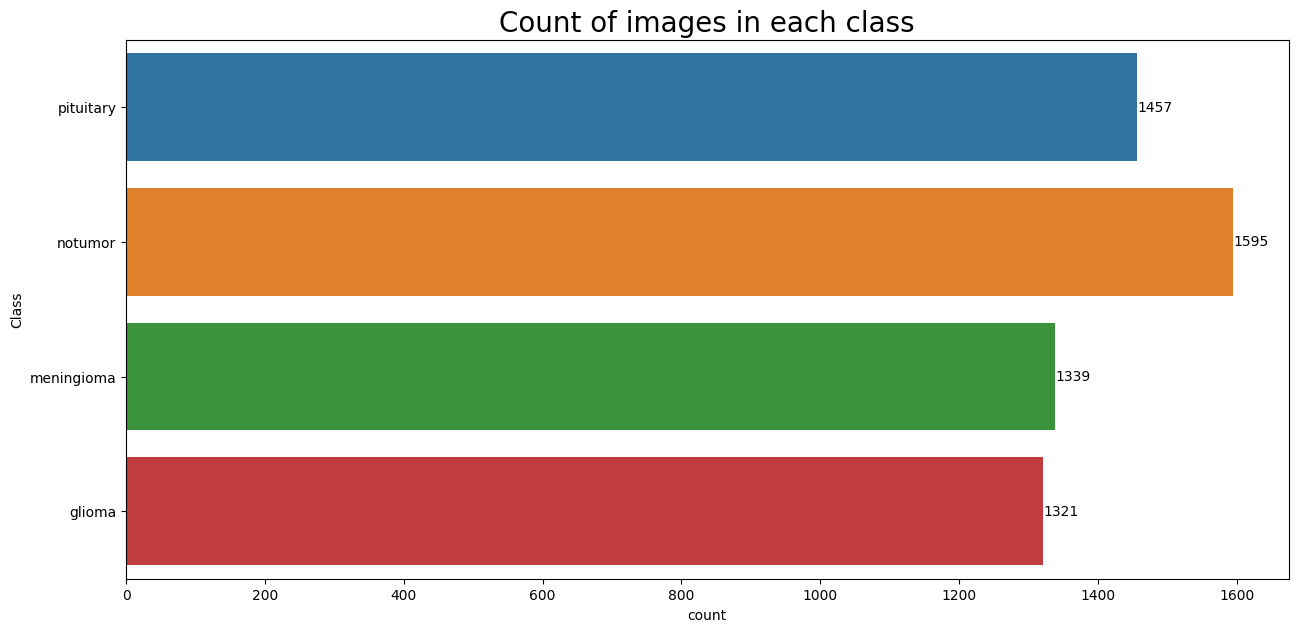

In [8]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_df , y=train_df['Class'])
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [9]:
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Class'])

In [10]:
valid_df

Class Path       Class
1297  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
723   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
61    /kaggle/input/brain-tumor-mri-dataset/Testing/...   pituitary
778   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
1120  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
...                                                 ...         ...
1070  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
554   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor
1284  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
899   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
626   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor

[655 rows x 2 columns]

In [11]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1.0/255, brightness_range=(0.8, 1.2),
                          rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                          shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                          fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1.0/255)

train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


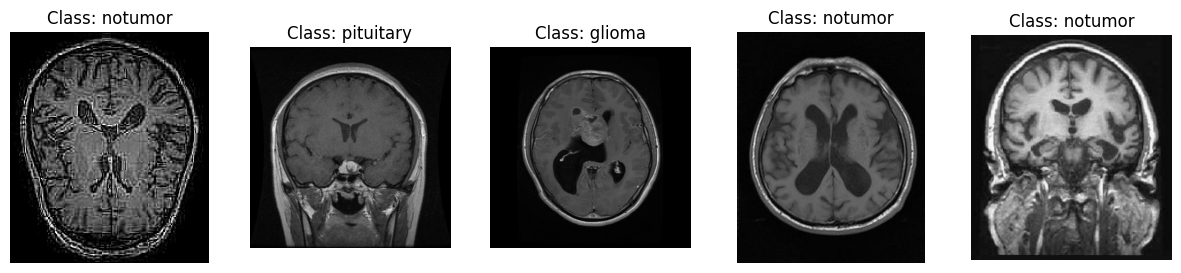

In [12]:
def display_random_images(df, num_images=5):
    random_indices = random.sample(range(len(df)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(random_indices):
        image_path = df.loc[idx, 'Class Path']
        class_name = df.loc[idx, 'Class']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {class_name}')
        axes[i].axis('off')
    plt.show()
display_random_images(train_df)

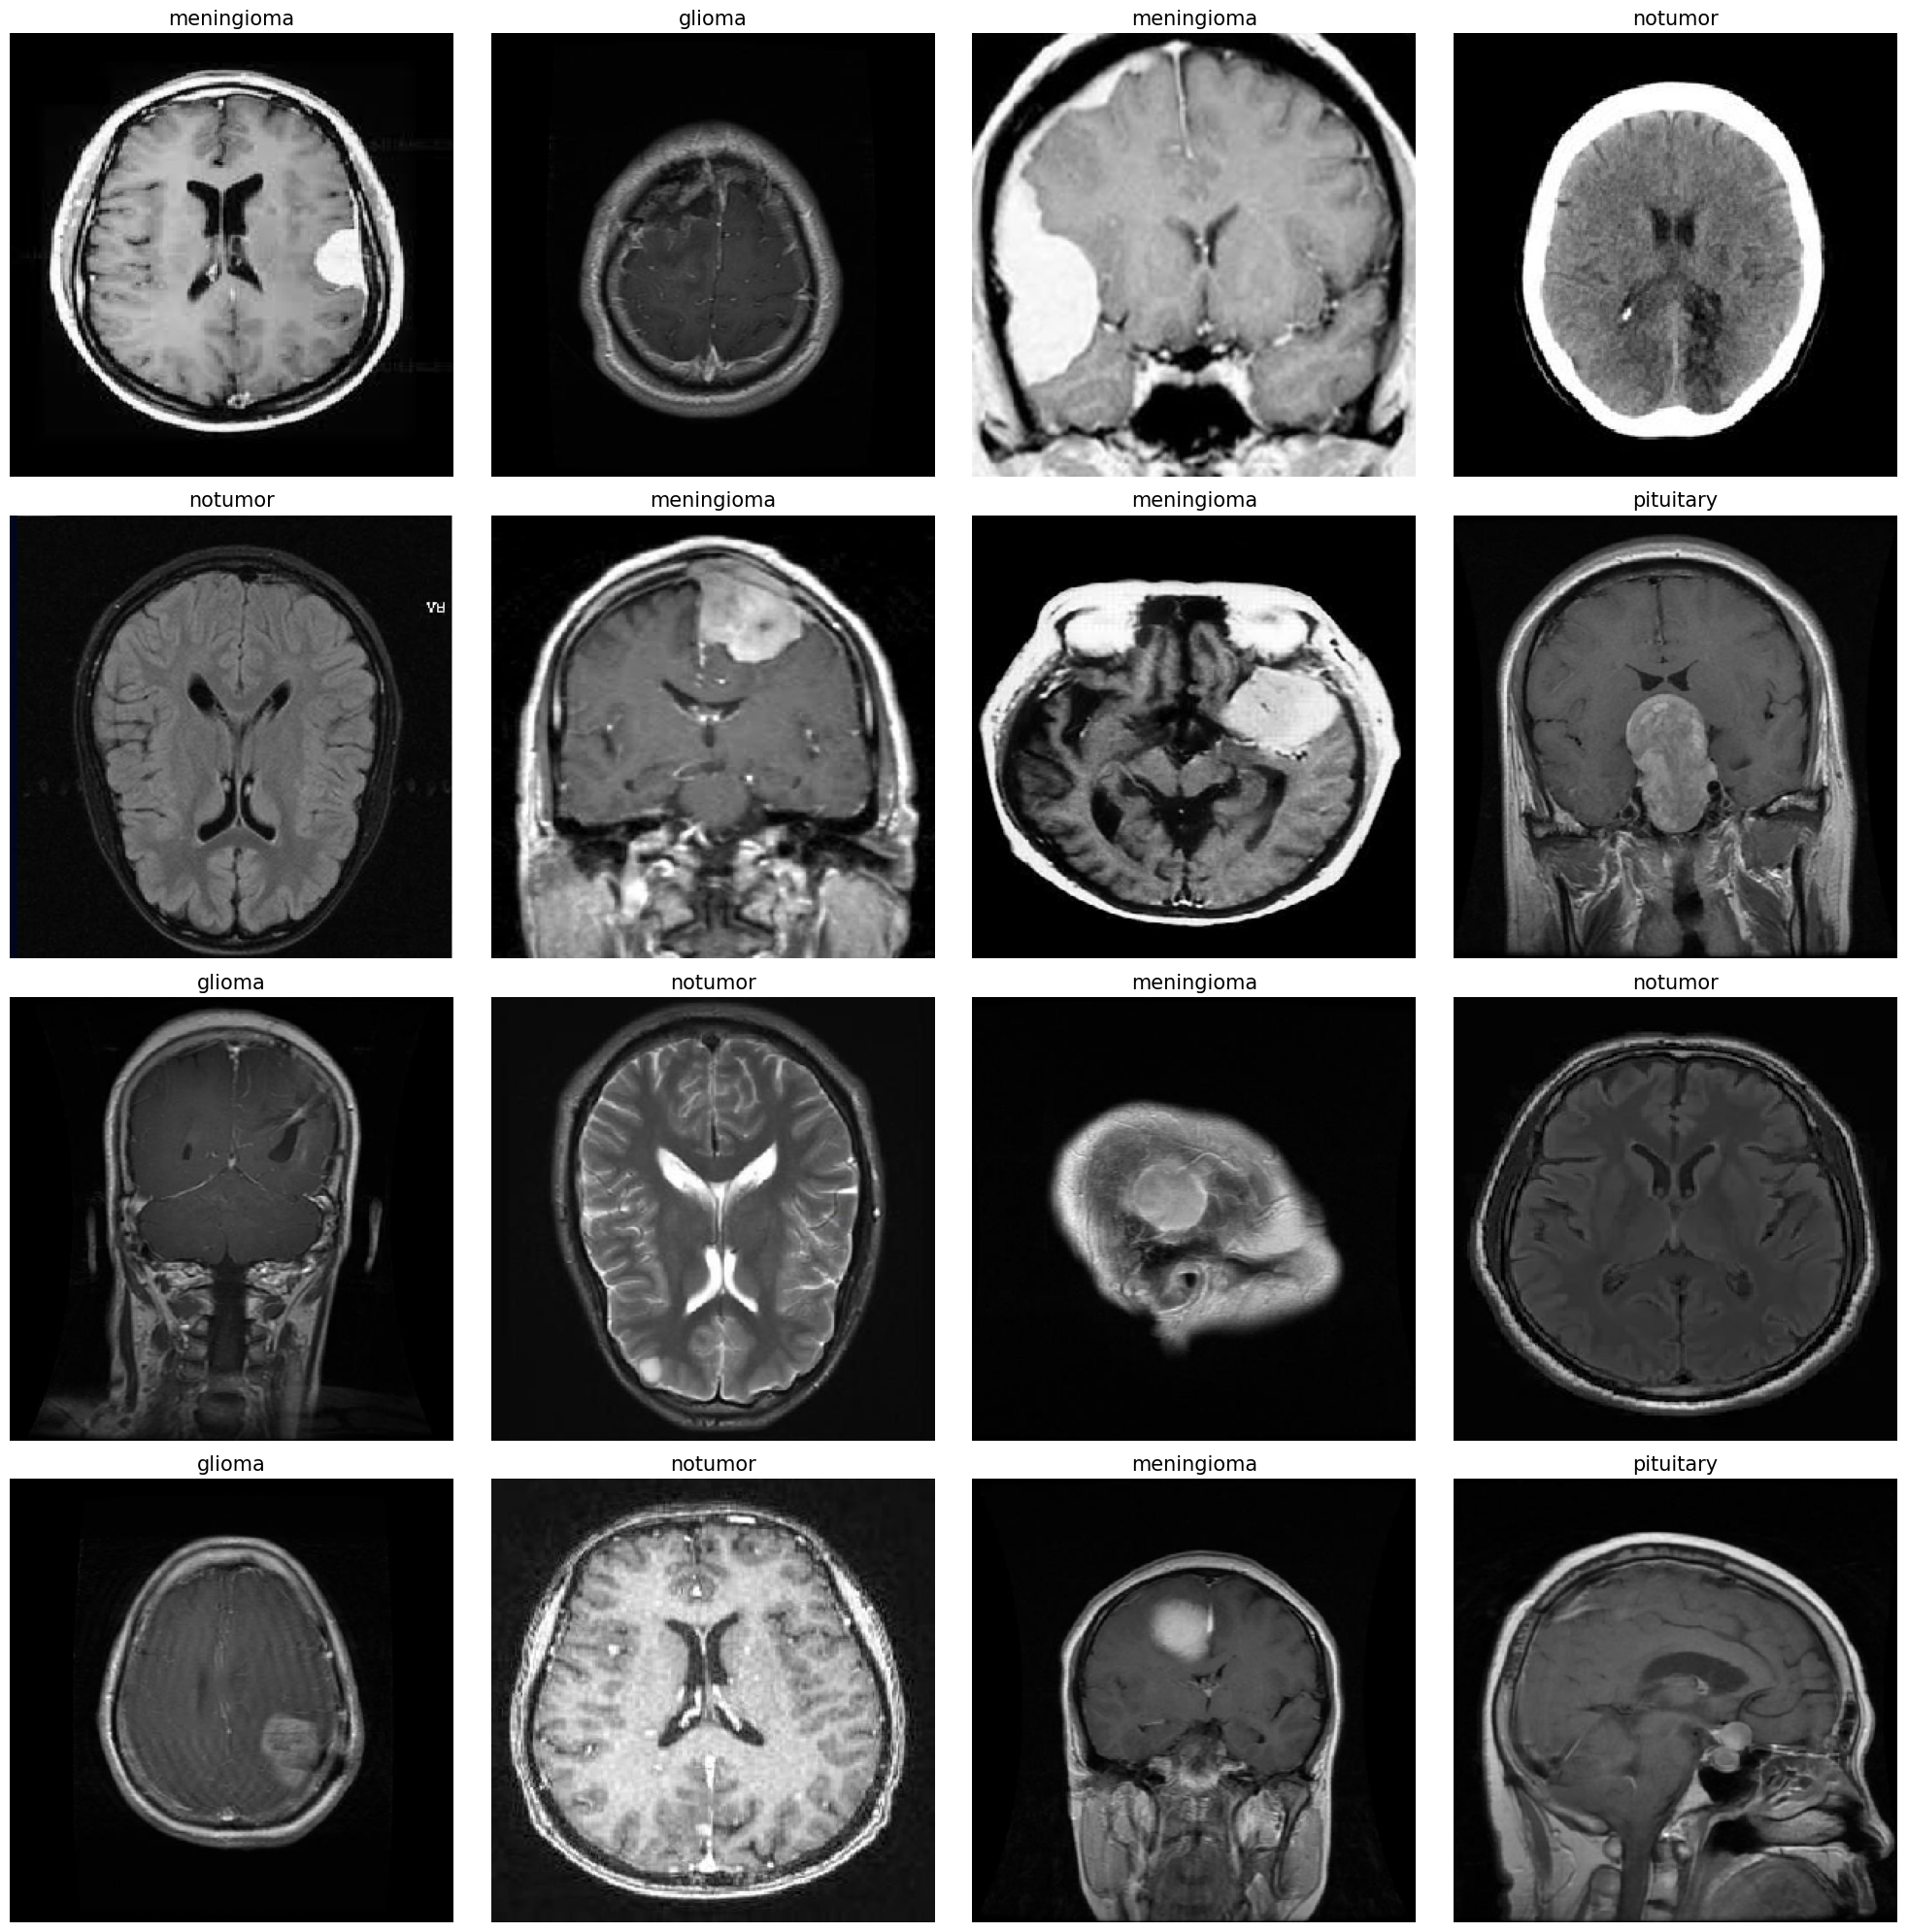

In [13]:
# class_dict = train_gen.class_indices
# classes = list(class_dict.keys())
# images, labels = next(test_gen)

# plt.figure(figsize=(20, 20))

# for i, (image, label) in enumerate(zip(images, labels)):
#     plt.subplot(4,4, i + 1)
#     plt.imshow(image)
#     class_name = classes[np.argmax(label)]
#     plt.title(class_name, color='k', fontsize=15)

# plt.show()

class_dict = train_gen.class_indices
classes = list(class_dict.keys())

# Get a batch of images and labels from the test generator
images, labels = next(test_gen)

plt.figure(figsize=(20, 20))

# Display a maximum of 16 images
num_images_to_display = min(len(images), 16)

for i in range(num_images_to_display):
    plt.subplot(4, 4, i + 1)  # Create a 4x4 grid of subplots
    plt.imshow(images[i])  # Display the image
    class_name = classes[np.argmax(labels[i])]  # Get the class name for the label
    plt.title(class_name, color='k', fontsize=15)  # Set the title with the class name
    plt.axis('off')  # Hide the axis

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()

In [14]:
from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
img_shape = (299, 299, 3)
# Load DenseNet models for feature extraction (without the final layers)
xception = Xception(include_top=False, weights="imagenet", input_shape=img_shape)
inceptionv3 = InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape)


# Freeze the base models
for model in [xception,inceptionv3]:
    model.trainable = False


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Concatenate, Dropout, Dense, 
    BatchNormalization, Lambda, Conv2D, Multiply, Add, Reshape, 
    AveragePooling2D, UpSampling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Define input shape and classes
IMG_SIZE = (299, 299)
NUM_CLASSES = 4
input_tensor = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Load pre-trained models
xception_model = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
inception_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Extract feature maps for FPN
xception_features = [
    xception_model.get_layer("block4_sepconv2").output,
    xception_model.get_layer("block13_sepconv2").output,
    xception_model.get_layer("block14_sepconv2_act").output
]
inception_features = [
    inception_model.get_layer("mixed2").output,
    inception_model.get_layer("mixed5").output,
    inception_model.get_layer("mixed10").output
]

from tensorflow.keras.layers import Resizing

def resize_to_match(x, target):
    target_height, target_width = target.shape[1], target.shape[2]  # Get static shape
    return Resizing(target_height, target_width, interpolation='bilinear')(x)


# Feature Pyramid Network (FPN)
def create_fpn(features):
    fpn_features = []
    for i in range(len(features) - 1, -1, -1):
        x = Conv2D(256, (1, 1), padding="same", activation="relu")(features[i])
        if i < len(features) - 1:
            upsampled = resize_to_match(fpn_features[-1], features[i])
            x = Add()([upsampled, Conv2D(256, (1, 1), padding="same", activation="relu")(features[i])])
        fpn_features.append(x)
    fpn_features.reverse()
    return fpn_features

# Apply FPN
xception_fpn = create_fpn(xception_features)
inception_fpn = create_fpn(inception_features)

# Align feature maps
aligned_xception_fpn = [resize_to_match(x_fpn, i_fpn) for x_fpn, i_fpn in zip(xception_fpn, inception_fpn)]
merged_features = [Concatenate()([x_fpn, i_fpn]) for x_fpn, i_fpn in zip(aligned_xception_fpn, inception_fpn)]

# Pooling across feature pyramid levels
# Pooling
pooled_features = [GlobalAveragePooling2D()(feature) for feature in merged_features]

# Fix: Reshape to 4D (batch_size, 1, 1, channels)
reshaped_features = [Reshape((1, 1, feature.shape[-1]))(feature) for feature in pooled_features]

# Concatenate reshaped features (keeps 4D shape)
concatenated_features = Concatenate()(reshaped_features)

# Multi-Scale Feature Extraction Module
def multi_scale_extraction(x):
    branch_1 = Conv2D(512, (1, 1), activation='relu', padding='same')(x)
    branch_2 = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    branch_3 = Conv2D(512, (5, 5), activation='relu', padding='same')(x)
    branch_4 = AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)
    branch_4 = Conv2D(512, (1, 1), activation='relu', padding='same')(branch_4)
    return Concatenate()([branch_1, branch_2, branch_3, branch_4])

# Dilated Convolution Module
def dilated_convolutions(x):
    dilated_1 = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=1)(x)
    dilated_2 = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=2)(x)
    dilated_3 = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=3)(x)
    return Add()([dilated_1, dilated_2, dilated_3])

# Apply multi-scale extraction and dilation
multi_scale_features = multi_scale_extraction(concatenated_features)
enhanced_features = dilated_convolutions(multi_scale_features)

# Spatial Attention Module
def spatial_attention(x):
    avg_pool = Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x)
    max_pool = Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    return Multiply()([x, attention])

# Channel Attention Module
def channel_attention(x):
    avg_pool = GlobalAveragePooling2D()(x)  
    dense = Dense(x.shape[-1] // 8, activation='relu')(avg_pool)
    attention = Dense(x.shape[-1], activation='sigmoid')(dense)
    attention = Reshape((1, 1, x.shape[-1]))(attention)
    return Multiply()([x, attention])

# Apply attention mechanisms
spatial_att = spatial_attention(enhanced_features)
channel_att = channel_attention(spatial_att)
attention_output = Add()([spatial_att, channel_att])

# Fully Connected Layers
x = GlobalAveragePooling2D()(attention_output)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Build and compile the model
model = Model(inputs=input_tensor, outputs=output)
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_218 (Conv2D)       │ (None, 149, 149, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_202   │ (None, 149, 149, 32)   │             96 │ conv2d_218[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 149, 149, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_219 (Conv2D)       │ (None, 147, 147, 32)   │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_203   │ (None, 147, 147, 32)   │             96 │ conv2d_219[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 147, 147, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_220 (Conv2D)       │ (None, 147, 147, 64)   │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_204   │ (None, 147, 147, 64)   │            192 │ conv2d_220[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 73, 73, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_221 (Conv2D)       │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_205   │ (None, 73, 73, 80)     │            240 │ conv2d_221[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 73, 73, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_222 (Conv2D)  

 Total params: 101,457,519 (387.03 MB)

 Trainable params: 101,367,279 (386.69 MB)

 Non-trainable params: 90,240 (352.50 KB)

In [17]:
# Train the model
hist = model.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

# Load the best model saved as .keras
model.load_weights('best_model.keras')

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.5891 - loss: 1.8373 - precision: 0.6294 - recall: 0.5409 - val_accuracy: 0.8275 - val_loss: 1.1629 - val_precision: 0.8528 - val_recall: 0.7786 - learning_rate: 1.0000e-04
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 179s 965ms/step - accuracy: 0.9398 - loss: 0.8913 - precision: 0.9487 - recall: 0.9348 - val_accuracy: 0.8702 - val_loss: 1.0712 - val_precision: 0.8738 - val_recall: 0.8672 - learning_rate: 1.0000e-04
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 176s 949ms/step - accuracy: 0.9570 - loss: 0.8138 - precision: 0.9603 - recall: 0.9536 - val_accuracy: 0.9786 - val_loss: 0.7439 - val_precision: 0.9815 - val_recall: 0.9710 - learning_rate: 1.0000e-04
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 175s 945ms/step - accuracy: 0.9709 - loss: 0.7455 - precision: 0.9729 - recall: 0.9683 - val_accuracy: 0.9771 - val_loss: 0.7013 - val_precision: 0.9801 - val_recall: 0.9756 - learning_rate: 1.0000e-04
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 

In [18]:
hist.history.keys()


dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

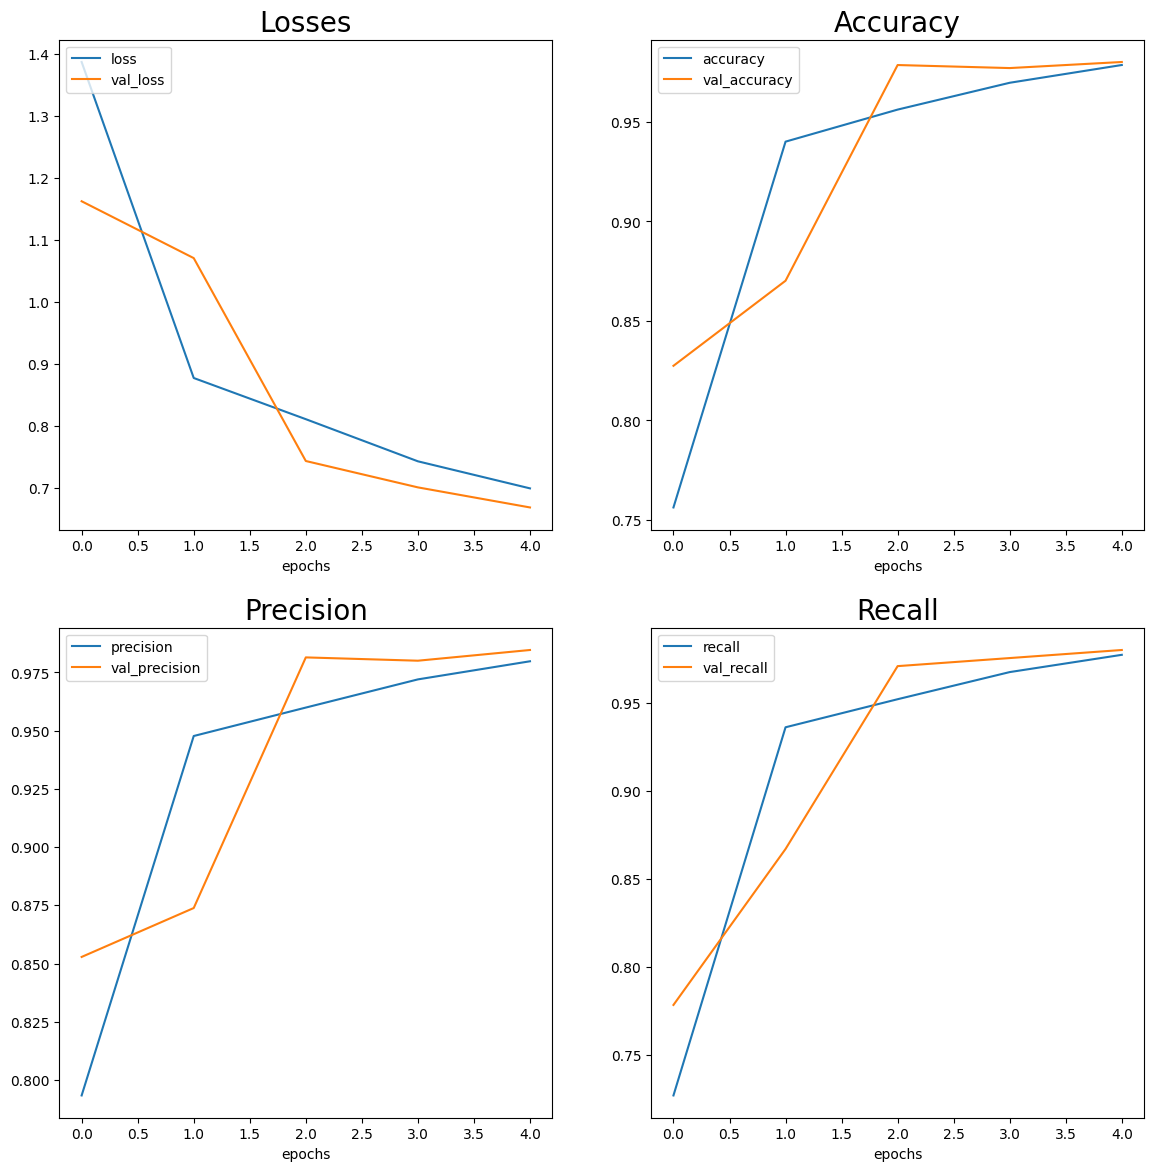

In [19]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")
plt.subplot(2, 2, 3)
plt.plot(hist.history['precision'], label='precision')
plt.plot(hist.history['val_precision'], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 4)
plt.plot(hist.history['recall'], label='recall')
plt.plot(hist.history['val_recall'], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.show()


In [20]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 144s 803ms/step - accuracy: 0.9856 - loss: 0.6760 - precision: 0.9870 - recall: 0.9845
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 727ms/step - accuracy: 0.9867 - loss: 0.6603 - precision: 0.9897 - recall: 0.9771
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.9808 - loss: 0.6746 - precision: 0.9808 - recall: 0.9804
Train Loss:  0.6717853546142578
Train Accuracy:  0.9863445162773132
--------------------
Validation Loss:  0.6690306067466736
Validation Accuracy:  0.9832060933113098
--------------------
Test Loss:  0.6778275966644287
Test Accuracy:  0.9832317233085632


In [21]:
from sklearn.metrics import classification_report
import numpy as np

# Generate predictions using the `predict` method
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Get true labels
y_true = test_gen.classes

# Get class names if not already defined
classes = list(test_gen.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=classes))


21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 598ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.99      0.98       150
  meningioma       0.99      0.94      0.97       153
     notumor       0.99      1.00      1.00       203
   pituitary       0.98      0.99      0.99       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



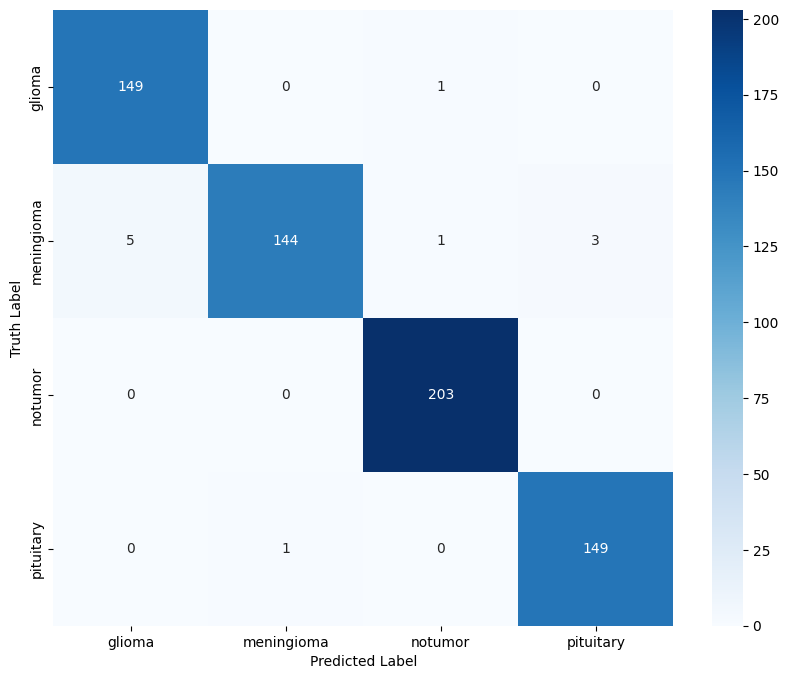

In [22]:
cm = confusion_matrix(test_gen.classes, y_pred)
labels = classes
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted Label: pituitary and Actual Label: pituitary


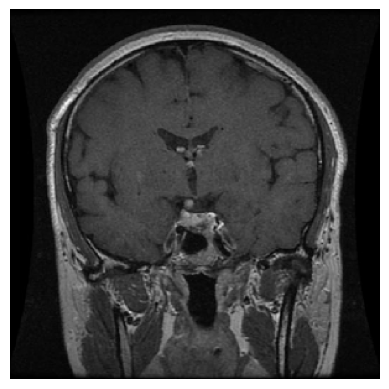

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Label: glioma and Actual Label: glioma


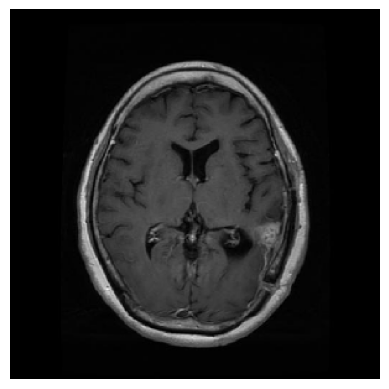

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Label: glioma and Actual Label: glioma


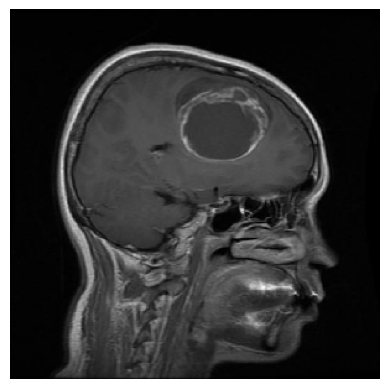

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Label: notumor and Actual Label: notumor


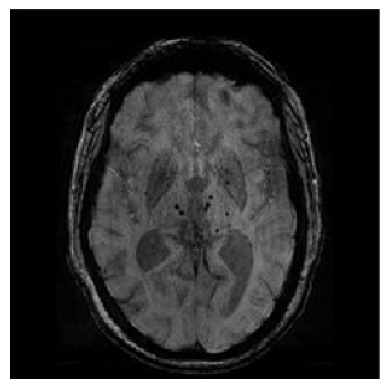

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Label: notumor and Actual Label: notumor


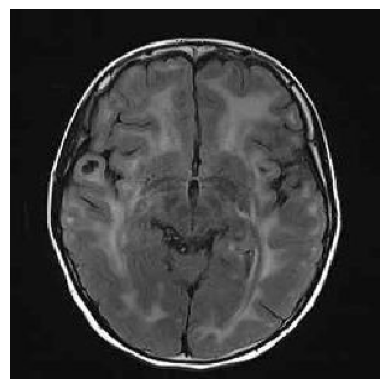

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Label: pituitary and Actual Label: pituitary


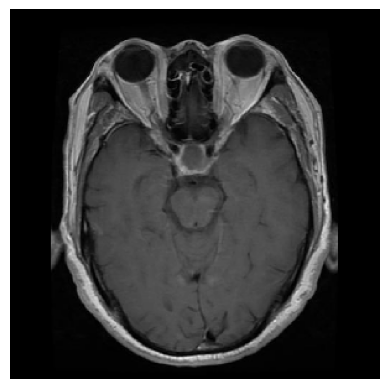

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Label: notumor and Actual Label: notumor


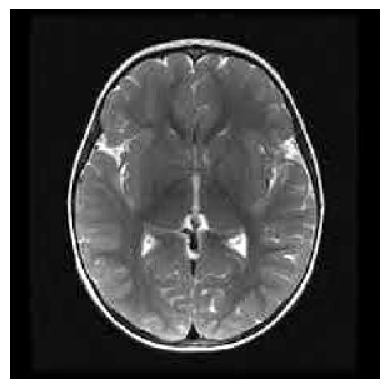

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Label: glioma and Actual Label: glioma


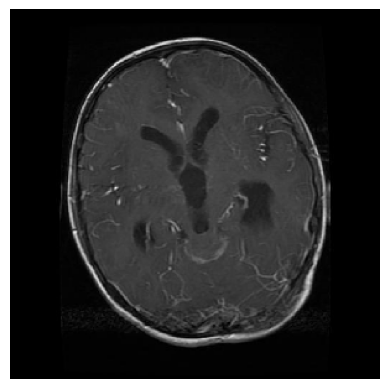

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Label: meningioma and Actual Label: meningioma


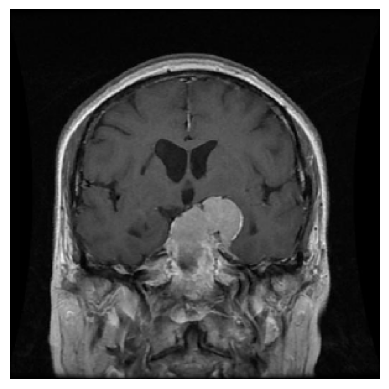

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Label: meningioma and Actual Label: meningioma


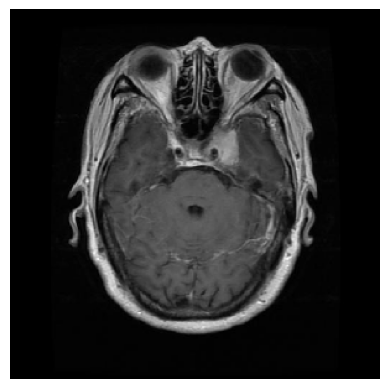

In [23]:
images_test, labels_test = next(iter(test_gen))

for i in range(10):
    plt.imshow(images_test[i])
    plt.axis('off')

    prediction = np.argmax(model.predict(images_test[i][np.newaxis, ...]))
    actual_label = np.argmax(labels_test[i])  # Convert one-hot to index

    print(f"Predicted Label: {classes[prediction]} and Actual Label: {classes[actual_label]}")
    plt.show()